# **Importing library&function**






In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [4]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.80,0.10,0.10))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [01:35, 44.23 files/s] 

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 108 images in './outputgrayscale/test/gray_normal'.
There are 0 directories and 111 images in './outputgrayscale/test/gray_diabetic_retinopathy'.
There are 0 directories and 103 images in './outputgrayscale/test/gray_glaucoma'.
There are 0 directories and 106 images in './outputgrayscale/test/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 859 images in './outputgrayscale/train/gray_normal'.
There are 0 directories and 879 images in './outputgrayscale/train/gray_diabetic_retinopathy'.
There are 0 directories and 813 images in './outputgrayscale/train/gray_glaucoma'.
There are 0 directories and 838 images in './outputgrayscale/train/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 107 images in './outputgrayscale/

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [6]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

# **Batch size: 16**

In [ ]:
epoch = 20
batchsize = 16

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 421 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [ ]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 2s 0us/step


In [ ]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
 activation (Activation)     (None, 4)                 0     

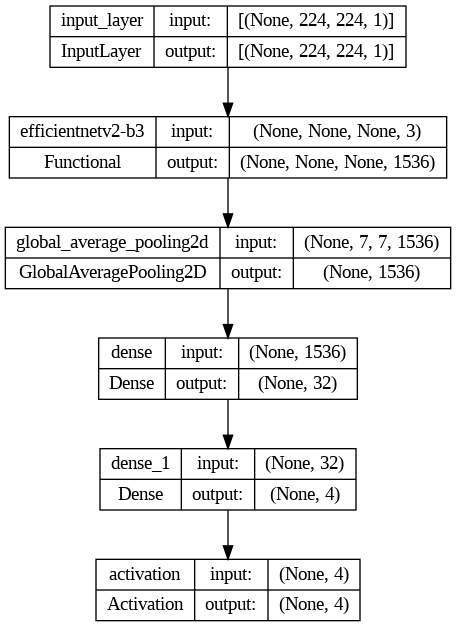

In [ ]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [ ]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 32s 66ms/step - loss: 0.6327 - accuracy: 0.7515 - val_loss: 0.4506 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 11s 50ms/step - loss: 0.4386 - accuracy: 0.8300 - val_loss: 0.4001 - val_accuracy: 0.8361 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 11s 50ms/step - loss: 0.3944 - accuracy: 0.8457 - val_loss: 0.3687 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 11s 50ms/step - loss: 0.3714 - accuracy: 0.8590 - val_loss: 0.3699 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 11s 51ms/step - loss: 0.3483 - accuracy: 0.8652 - val_loss: 0.3457 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 11s 50ms/step - loss: 0.3299 - accuracy: 0.8725 - val_loss: 0.3208 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 7/20
212/212 [==============================] - 11s 

EfficientNetV2B3 Evaluation

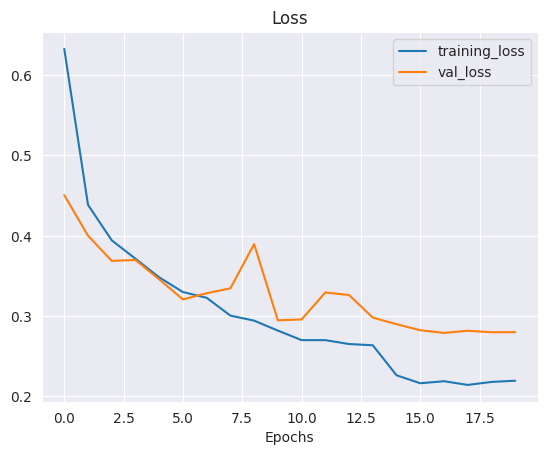

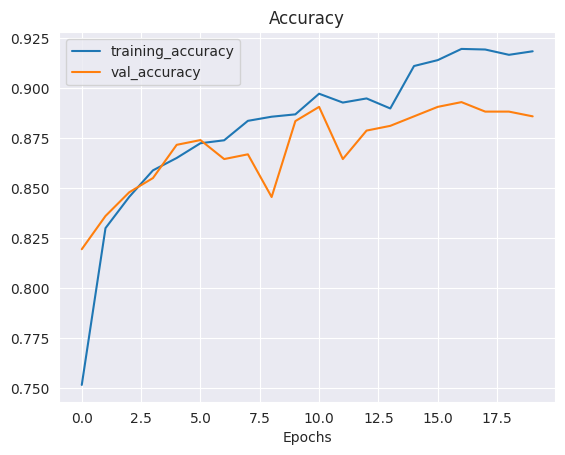

In [ ]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 41ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       106
           1       0.97      0.96      0.97       111
           2       0.85      0.82      0.83       103
           3       0.86      0.87      0.87       108

    accuracy                           0.90       428
   macro avg       0.90      0.90      0.90       428
weighted avg       0.90      0.90      0.90       428

Specificity: [0.3009118541033435, 0.3333333333333333, 0.2441860465116279, 0.281437125748503]
Mean Squared Error: : 0.1100858524441719
The average AUC-ROC is 0.9879729936889349


[0.9779874213836478,
 0.6666666666666666,
 0.6899696048632219,
 0.677115987460815,
 0.6509433962264151,
 0.9874213836477987,
 0.6656534954407295,
 0.6614420062695925,
 0.7044025157232704,
 0.6792452830188679,
 0.9422492401215805,
 0.7053291536050157,
 0.6666666666666666,
 0.6666666666666666,
 0.7021276595744681,
 0.9561128526645768]

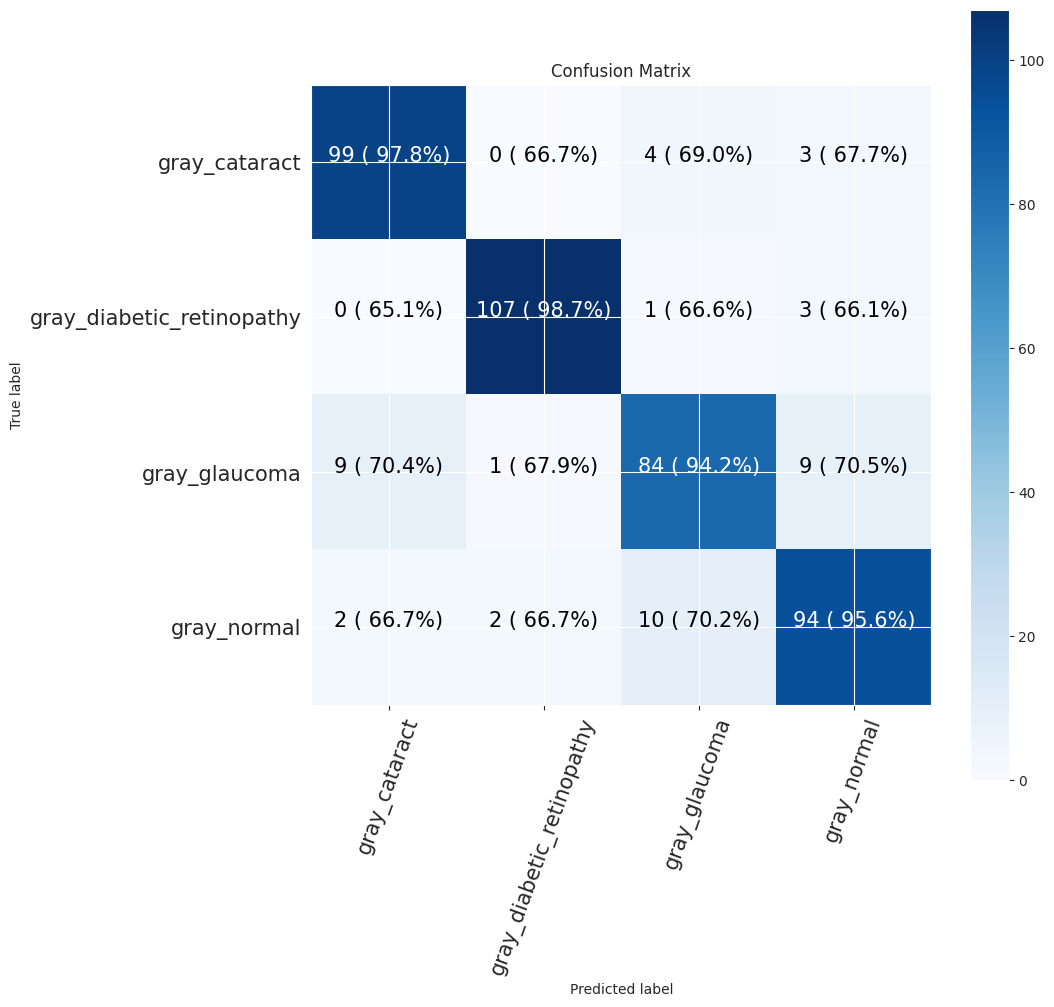

In [ ]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


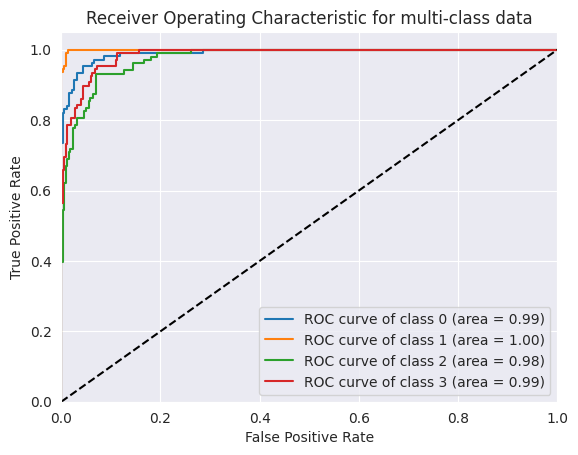

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [ ]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

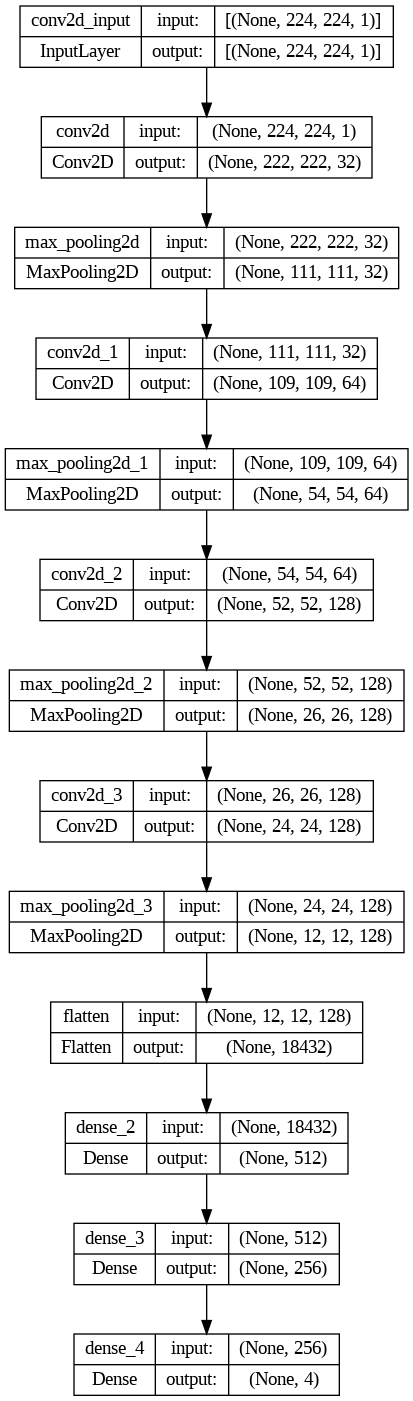

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [ ]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 8s 22ms/step - loss: 1.4894 - accuracy: 0.6046 - val_loss: 0.7671 - val_accuracy: 0.6817 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 4s 19ms/step - loss: 0.6289 - accuracy: 0.7191 - val_loss: 0.6166 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 4s 19ms/step - loss: 0.5975 - accuracy: 0.7418 - val_loss: 0.6563 - val_accuracy: 0.7435 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 4s 19ms/step - loss: 0.5087 - accuracy: 0.7766 - val_loss: 0.5645 - val_accuracy: 0.7743 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 4s 19ms/step - loss: 0.4519 - accuracy: 0.8132 - val_loss: 0.5484 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 4s 19ms/step - loss: 0.4287 - accuracy: 0.8159 - val_loss: 0.5594 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 7/20
212/212 [==============================] - 4s 19ms/st

CNN Evaluation

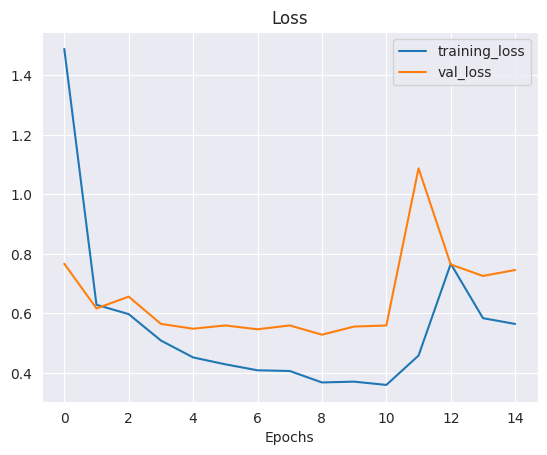

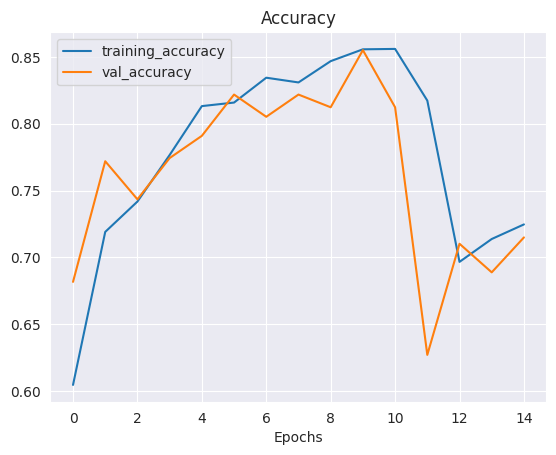

In [ ]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.72      0.65       106
           1       0.98      1.00      0.99       111
           2       0.76      0.21      0.33       103
           3       0.67      0.98      0.80       108

    accuracy                           0.74       428
   macro avg       0.75      0.73      0.69       428
weighted avg       0.75      0.74      0.70       428

Specificity: [0.2159090909090909, 0.3501577287066246, 0.054187192118226604, 0.32919254658385094]
Mean Squared Error: : 0.13863393664360046
The average AUC-ROC is 0.8973859633220655


[0.9,
 0.6666666666666666,
 0.7493734335839599,
 0.6925925925925925,
 0.63,
 1.0,
 0.7218045112781954,
 0.5888888888888889,
 0.83,
 0.6730158730158731,
 0.7969924812030075,
 0.725925925925926,
 0.64,
 0.6603174603174603,
 0.731829573934837,
 0.9925925925925926]

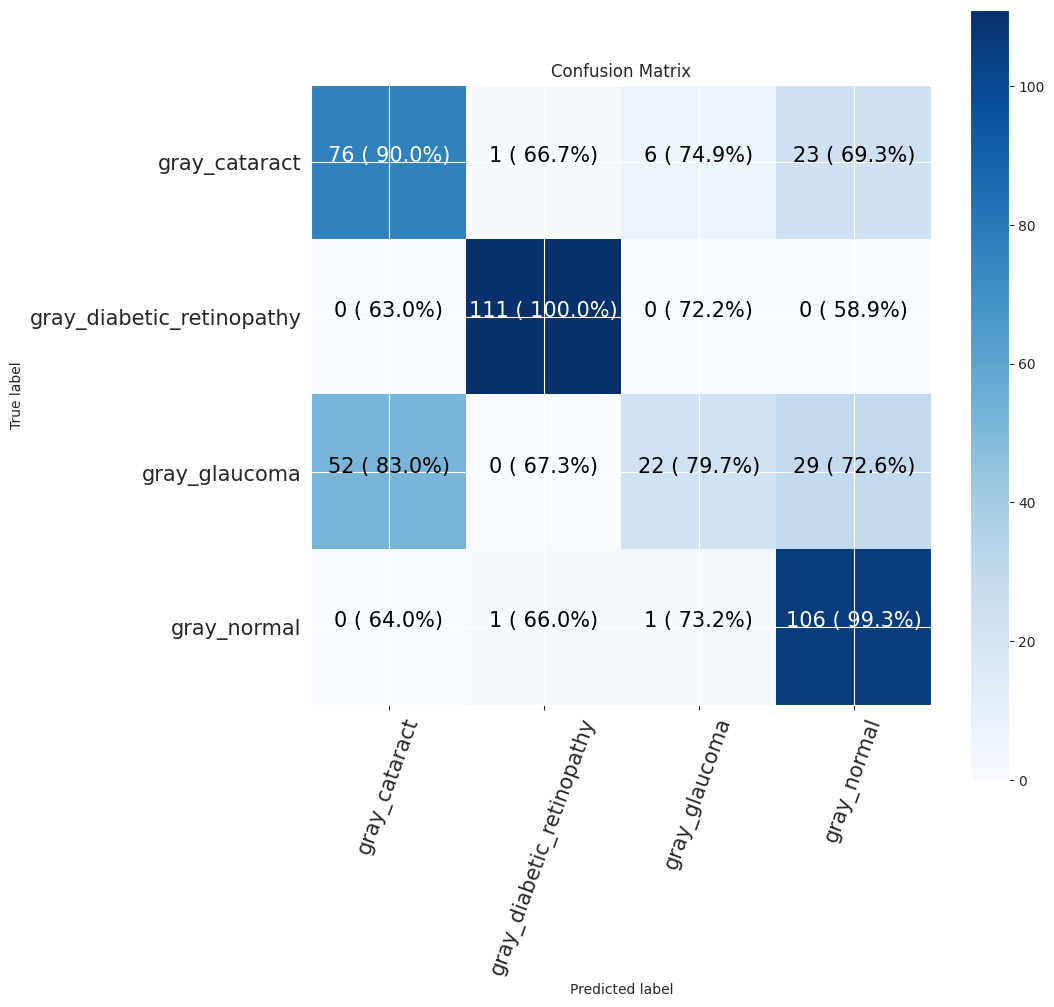

In [ ]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


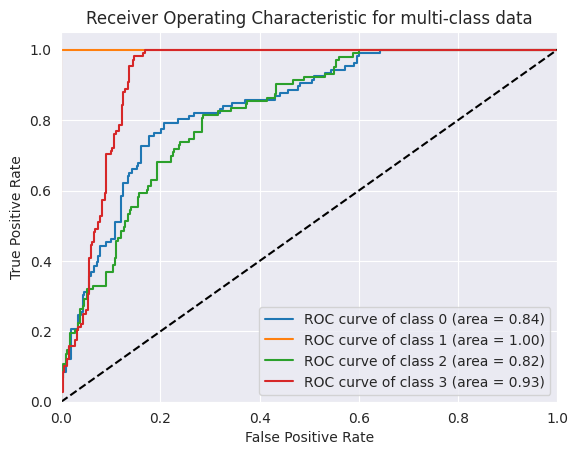

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [ ]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_28 (Dense)            (None, 4)                 4100      
                                                           

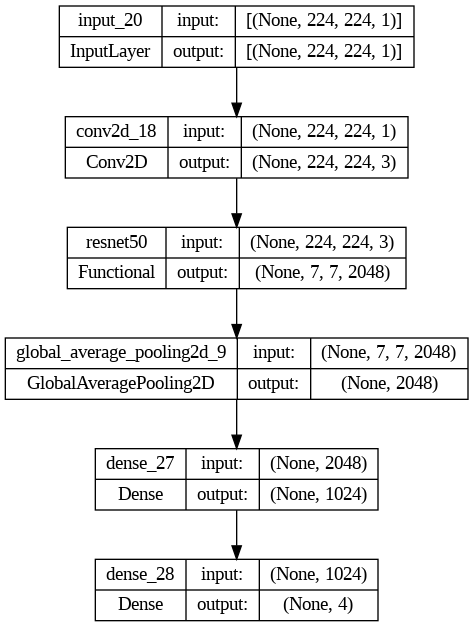

In [ ]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [ ]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 33s 140ms/step - loss: 0.6492 - accuracy: 0.7793 - val_loss: 0.5349 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 29s 135ms/step - loss: 0.3407 - accuracy: 0.8669 - val_loss: 0.3141 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 28s 133ms/step - loss: 0.3214 - accuracy: 0.8734 - val_loss: 0.3607 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 29s 135ms/step - loss: 0.2610 - accuracy: 0.9020 - val_loss: 0.2825 - val_accuracy: 0.9074 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 29s 135ms/step - loss: 0.2526 - accuracy: 0.8994 - val_loss: 0.2996 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 28s 134ms/step - loss: 0.2286 - accuracy: 0.9135 - val_loss: 0.3509 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 7/20
212/212 [==============================] 

ResNet50 Evaluation

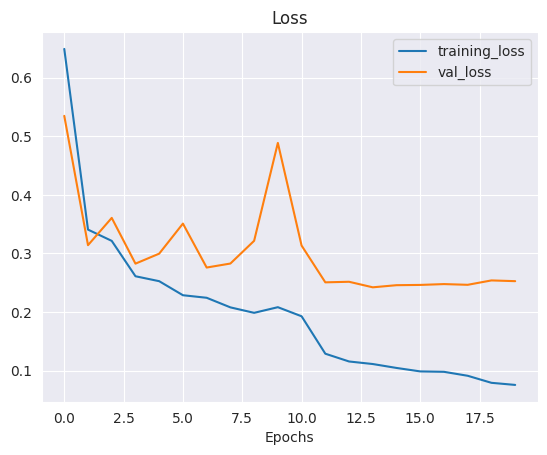

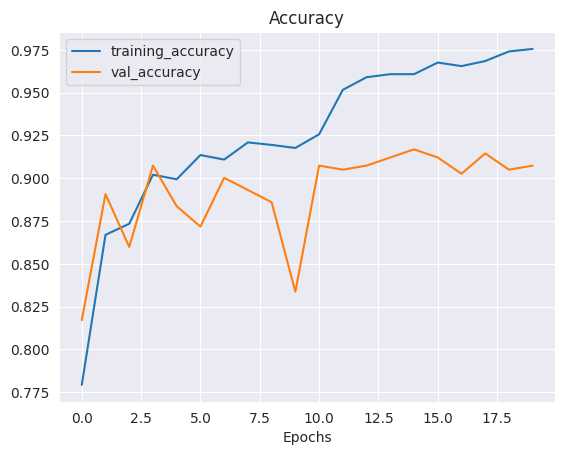

In [ ]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 48ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       106
           1       1.00      1.00      1.00       111
           2       0.86      0.81      0.83       103
           3       0.88      0.87      0.87       108

    accuracy                           0.91       428
   macro avg       0.91      0.90      0.90       428
weighted avg       0.91      0.91      0.91       428

Specificity: [0.3048780487804878, 0.3501577287066246, 0.24057971014492754, 0.281437125748503]
Mean Squared Error: : 0.10685019940137863
The average AUC-ROC is 0.9863626293566707


[0.9808917197452229,
 0.6656151419558359,
 0.6897590361445783,
 0.6791277258566978,
 0.6464968152866242,
 1.0,
 0.6656626506024096,
 0.6542056074766355,
 0.7038216560509554,
 0.6750788643533123,
 0.9397590361445783,
 0.7102803738317757,
 0.6687898089171974,
 0.6593059936908517,
 0.7048192771084337,
 0.956386292834891]

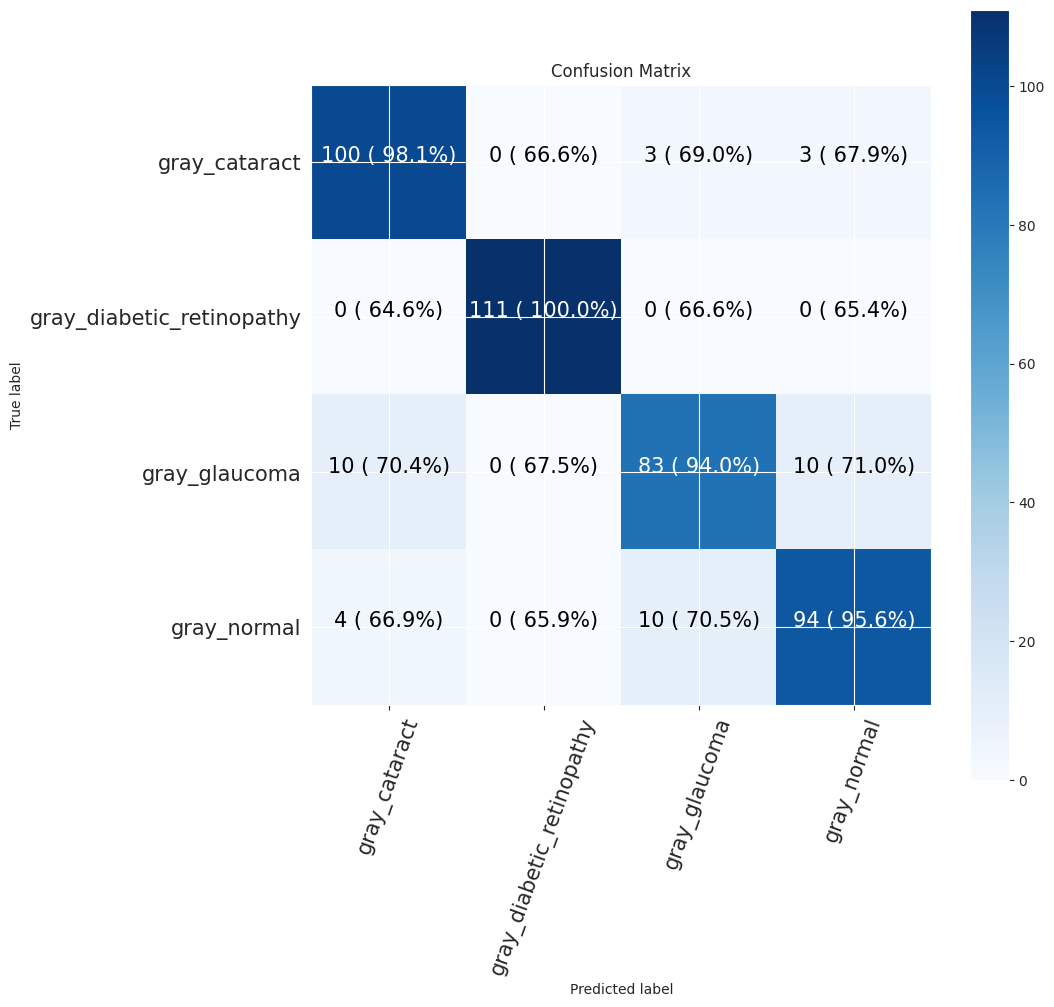

In [ ]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


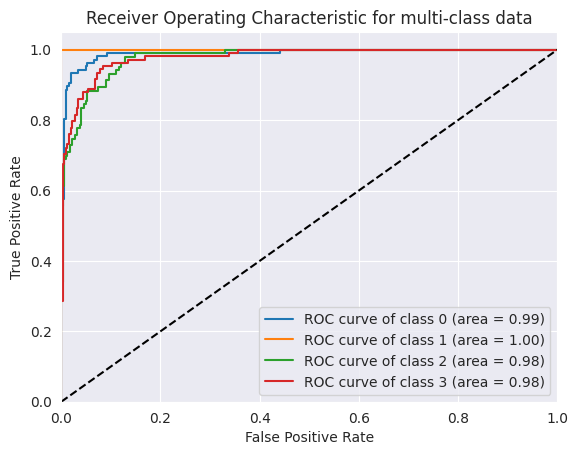

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [ ]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_29 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_30 (Dense)            (None, 4)                 4100      
                                                          

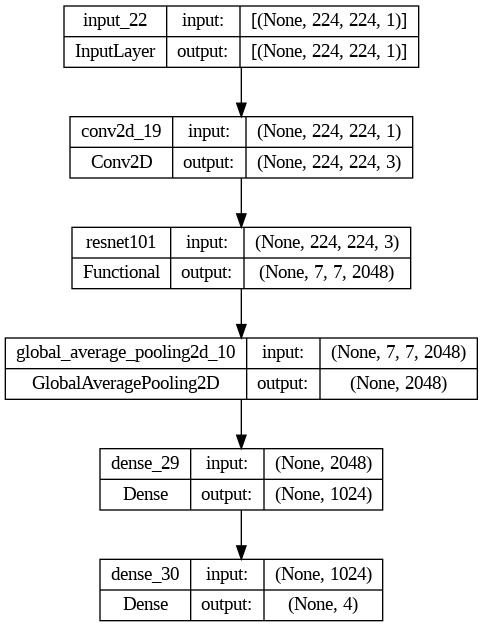

In [ ]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [ ]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 55s 229ms/step - loss: 0.7745 - accuracy: 0.7265 - val_loss: 0.5140 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 46s 219ms/step - loss: 0.4458 - accuracy: 0.8265 - val_loss: 0.3991 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 47s 220ms/step - loss: 0.3764 - accuracy: 0.8569 - val_loss: 0.4161 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 47s 219ms/step - loss: 0.3347 - accuracy: 0.8684 - val_loss: 0.4315 - val_accuracy: 0.8242 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 47s 219ms/step - loss: 0.3098 - accuracy: 0.8725 - val_loss: 0.3542 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 47s 220ms/step - loss: 0.2780 - accuracy: 0.8896 - val_loss: 0.3695 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 7/20
212/212 [==============================] 

ResNet101 Evaluation

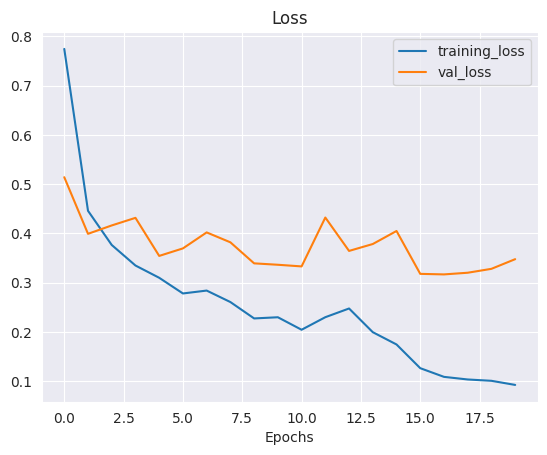

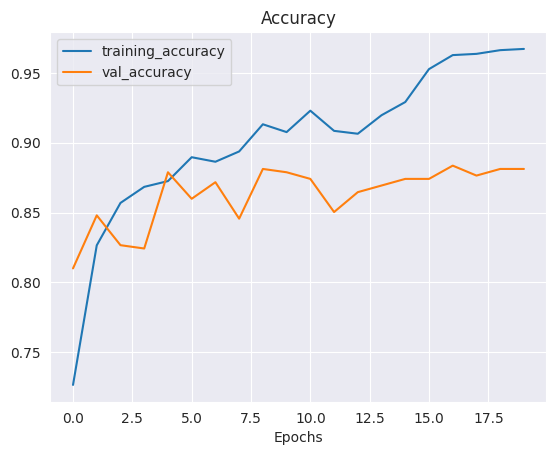

In [ ]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 2s 81ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       106
           1       0.99      1.00      1.00       111
           2       0.74      0.89      0.81       103
           3       0.91      0.77      0.83       108

    accuracy                           0.88       428
   macro avg       0.89      0.88      0.88       428
weighted avg       0.89      0.88      0.88       428

Specificity: [0.27380952380952384, 0.3501577287066246, 0.27380952380952384, 0.24057971014492754]
Mean Squared Error: : 0.11122212558984756
The average AUC-ROC is 0.9829220610510483


[0.9571865443425076,
 0.6645569620253164,
 0.6875,
 0.6943620178041543,
 0.6605504587155964,
 1.0,
 0.6348684210526315,
 0.6706231454005934,
 0.7003058103975535,
 0.6772151898734177,
 0.9638157894736842,
 0.7091988130563798,
 0.6819571865443425,
 0.6582278481012658,
 0.7138157894736842,
 0.9258160237388724]

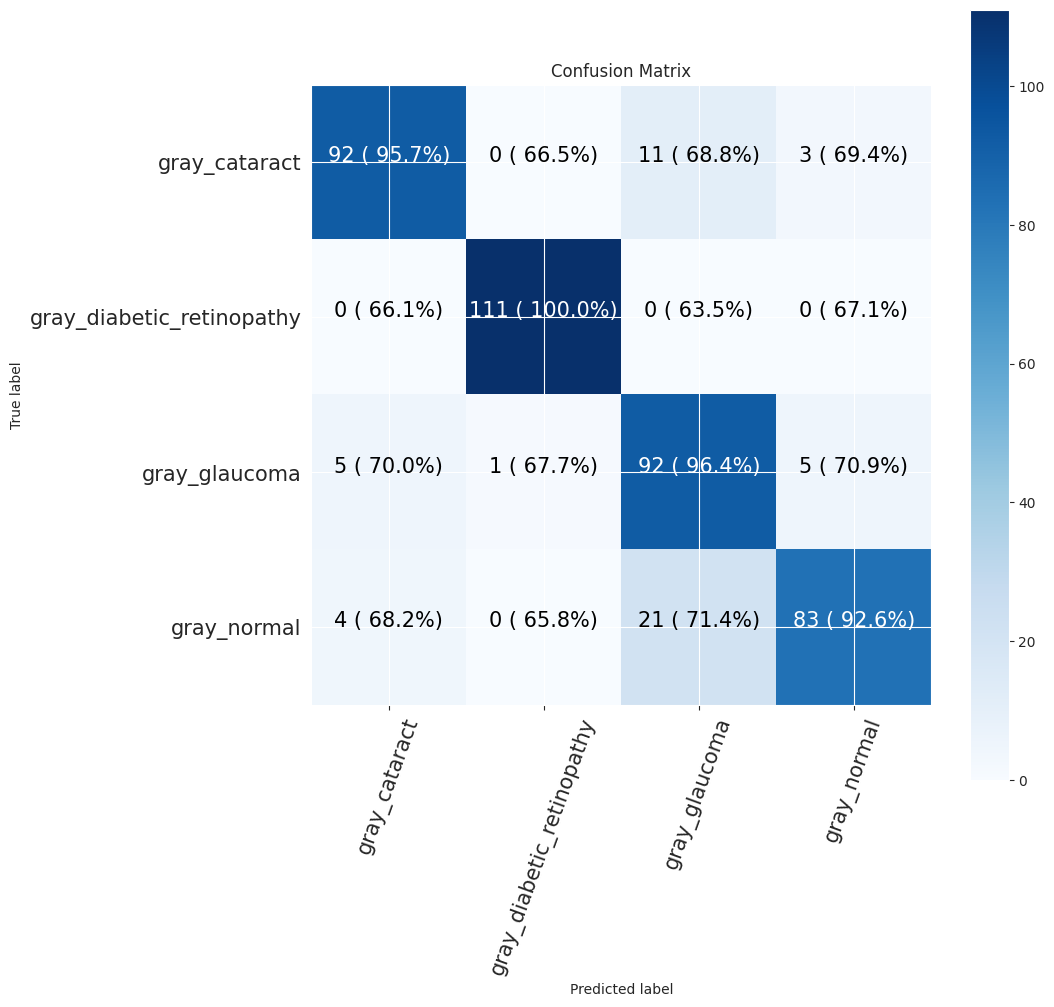

In [ ]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


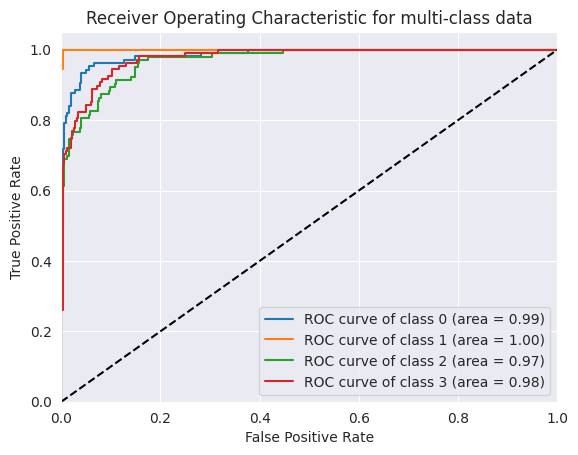

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [ ]:
epoch = 20
batchsize = 32

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 421 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [ ]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [ ]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 32)                49184     
                                                                 
 dense_10 (Dense)            (None, 4)                 132       
                                                                 
 activation_1 (Activation)   (None, 4)                 0   

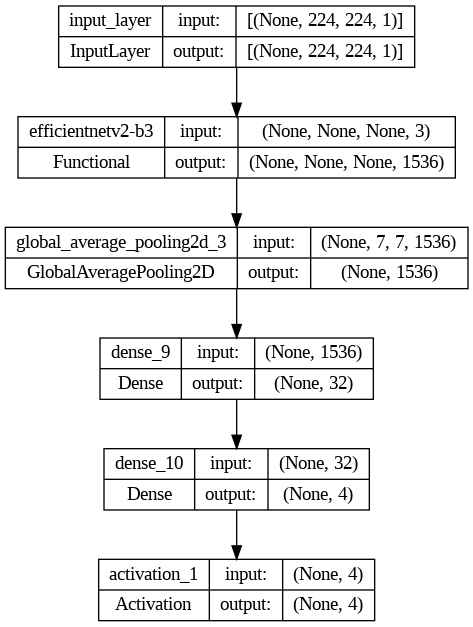

In [ ]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [ ]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 24s 123ms/step - loss: 0.6784 - accuracy: 0.7347 - val_loss: 0.5245 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 10s 95ms/step - loss: 0.4768 - accuracy: 0.8224 - val_loss: 0.4433 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 10s 95ms/step - loss: 0.4194 - accuracy: 0.8413 - val_loss: 0.4037 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 10s 95ms/step - loss: 0.3713 - accuracy: 0.8566 - val_loss: 0.3919 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 10s 95ms/step - loss: 0.3582 - accuracy: 0.8643 - val_loss: 0.3766 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 10s 94ms/step - loss: 0.3511 - accuracy: 0.8652 - val_loss: 0.3798 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 7/20
106/106 [==============================] - 10s

EfficientNetV2B3 Evaluation

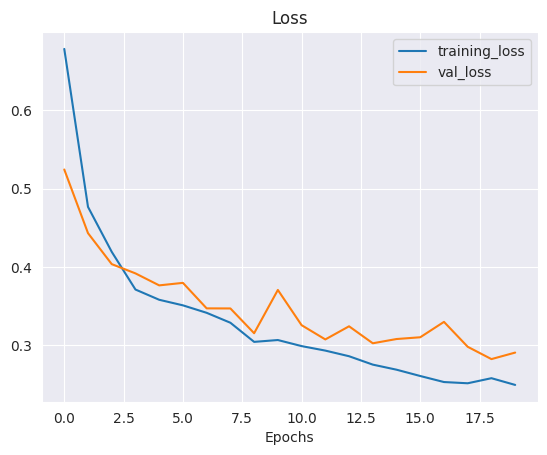

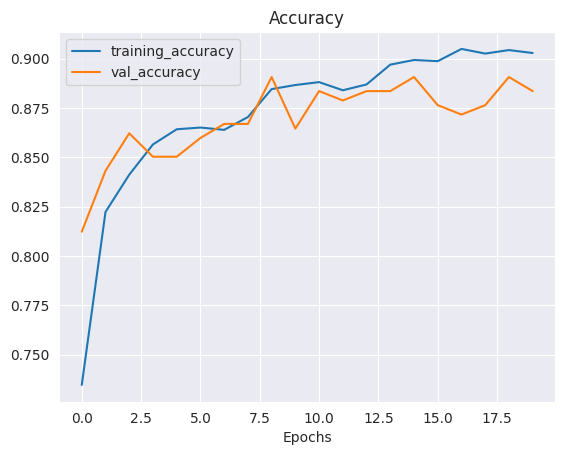

In [ ]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 76ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       106
           1       0.97      1.00      0.99       111
           2       0.87      0.82      0.84       103
           3       0.89      0.90      0.89       108

    accuracy                           0.91       428
   macro avg       0.91      0.91      0.91       428
weighted avg       0.91      0.91      0.91       428

Specificity: [0.3009118541033435, 0.3501577287066246, 0.2441860465116279, 0.2930513595166163]
Mean Squared Error: : 0.1091676652431488
The average AUC-ROC is 0.9865892343070704


[0.978125,
 0.6624203821656051,
 0.6918429003021148,
 0.677115987460815,
 0.653125,
 1.0,
 0.6646525679758308,
 0.6520376175548589,
 0.703125,
 0.678343949044586,
 0.9425981873111783,
 0.7053291536050157,
 0.665625,
 0.6592356687898089,
 0.7009063444108762,
 0.9655172413793104]

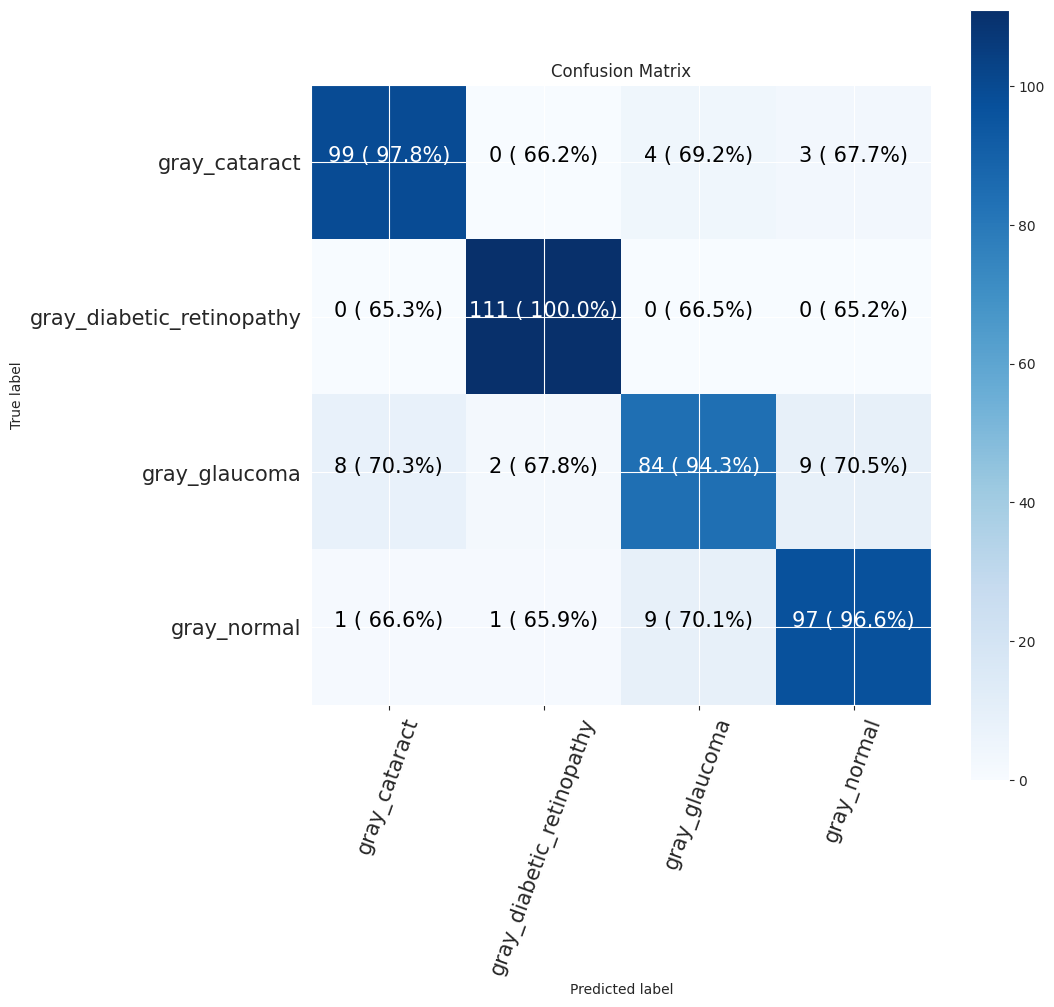

In [ ]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


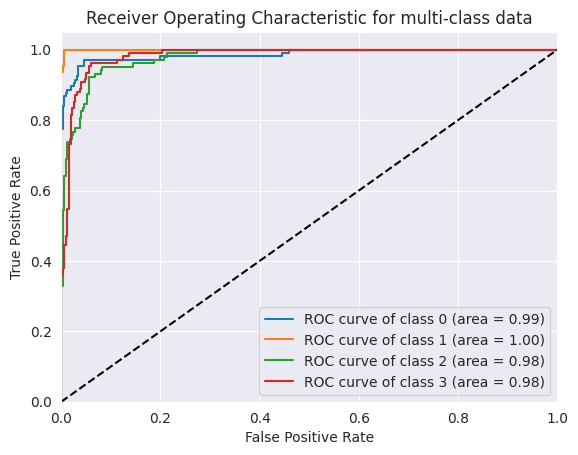

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [ ]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

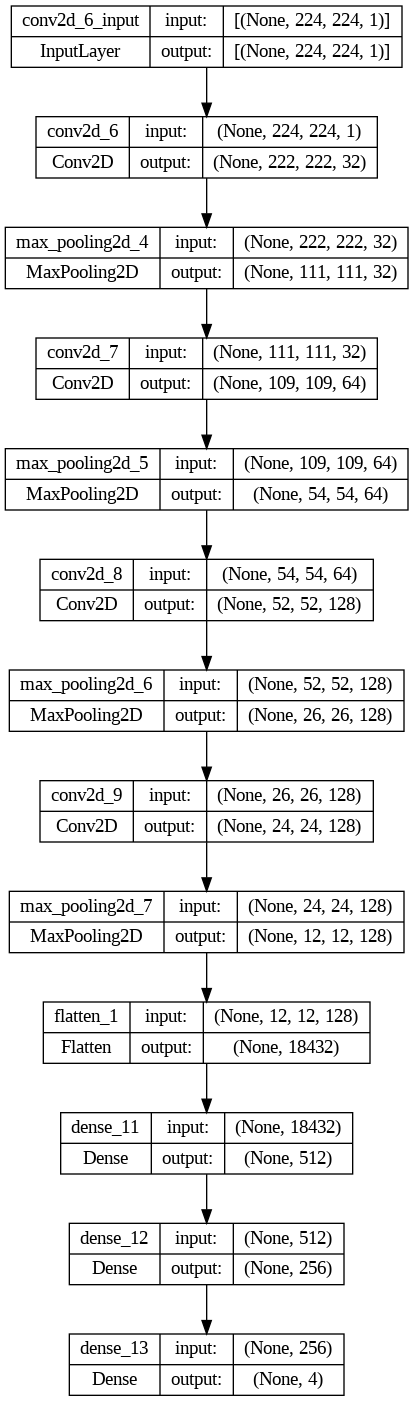

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [ ]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 6s 40ms/step - loss: 3.9903 - accuracy: 0.5285 - val_loss: 0.8866 - val_accuracy: 0.6342 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 4s 33ms/step - loss: 0.8332 - accuracy: 0.6371 - val_loss: 0.6865 - val_accuracy: 0.6865 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 4s 33ms/step - loss: 0.6557 - accuracy: 0.6958 - val_loss: 0.6965 - val_accuracy: 0.6817 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 4s 33ms/step - loss: 0.6140 - accuracy: 0.7099 - val_loss: 0.6627 - val_accuracy: 0.7055 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 4s 33ms/step - loss: 0.6281 - accuracy: 0.7138 - val_loss: 0.7104 - val_accuracy: 0.7245 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 4s 33ms/step - loss: 0.5900 - accuracy: 0.7315 - val_loss: 0.7134 - val_accuracy: 0.7102 - lr: 0.0010
Epoch 7/20
106/106 [==============================] - 4s 33ms/st

CNN Evaluation

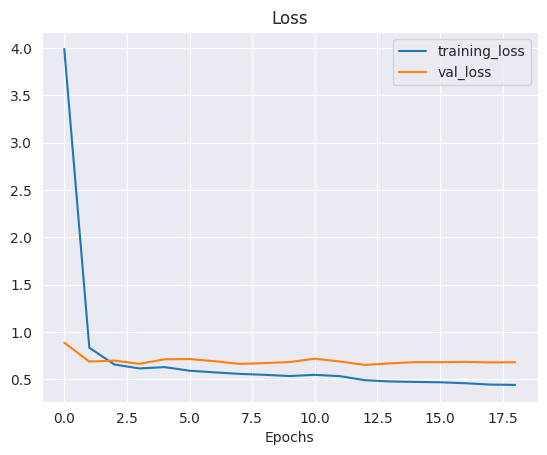

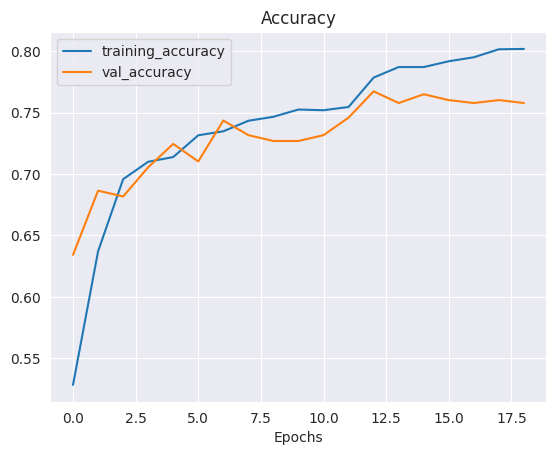

In [ ]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 12ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       106
           1       1.00      1.00      1.00       111
           2       0.60      0.48      0.53       103
           3       0.71      0.90      0.80       108

    accuracy                           0.74       428
   macro avg       0.73      0.74      0.73       428
weighted avg       0.74      0.74      0.73       428

Specificity: [0.16621253405994552, 0.3501577287066246, 0.12928759894459102, 0.2930513595166163]
Mean Squared Error: : 0.13522537052631378
The average AUC-ROC is 0.9104054825231278


[0.8632218844984803,
 0.6656151419558359,
 0.7745664739884393,
 0.6952054794520548,
 0.662613981762918,
 1.0,
 0.6791907514450867,
 0.6198630136986302,
 0.78419452887538,
 0.6750788643533123,
 0.8439306358381503,
 0.7226027397260274,
 0.6899696048632219,
 0.6593059936908517,
 0.7023121387283237,
 0.9623287671232876]

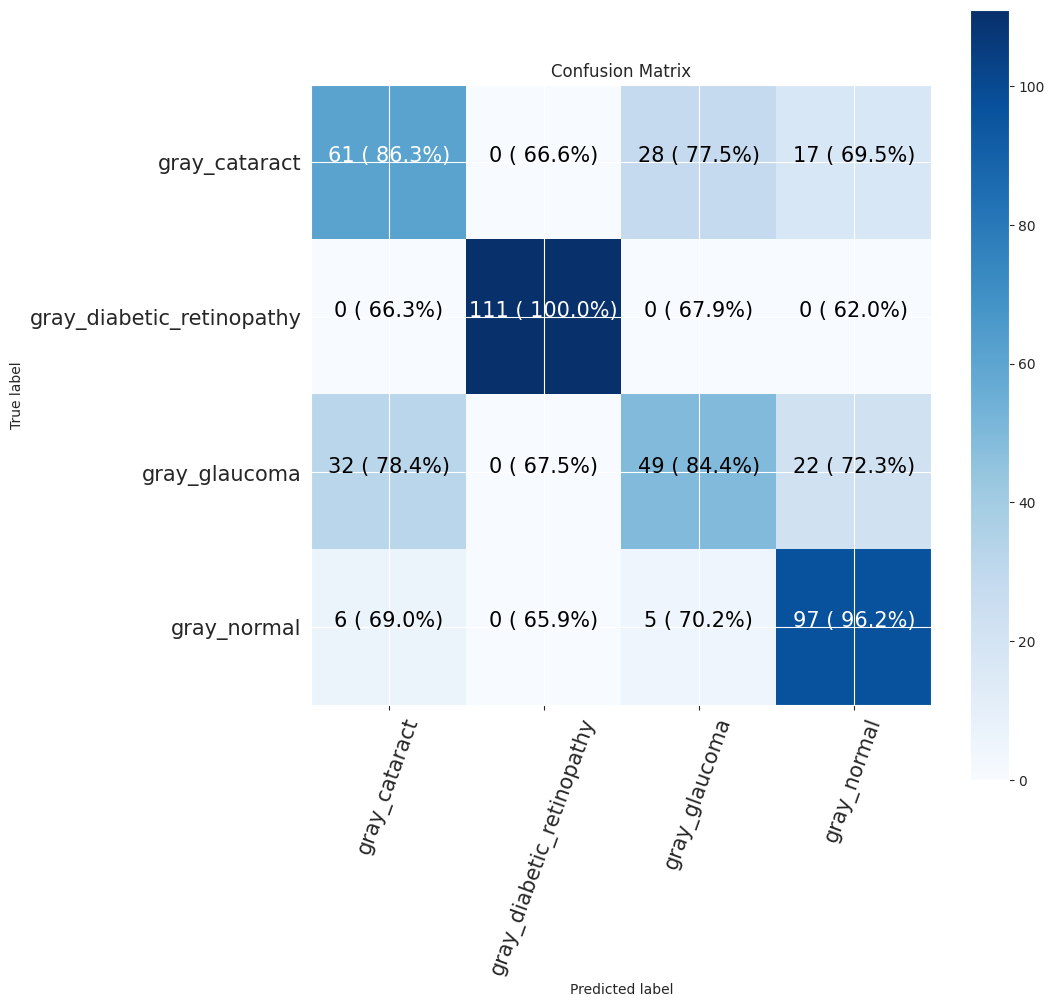

In [ ]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


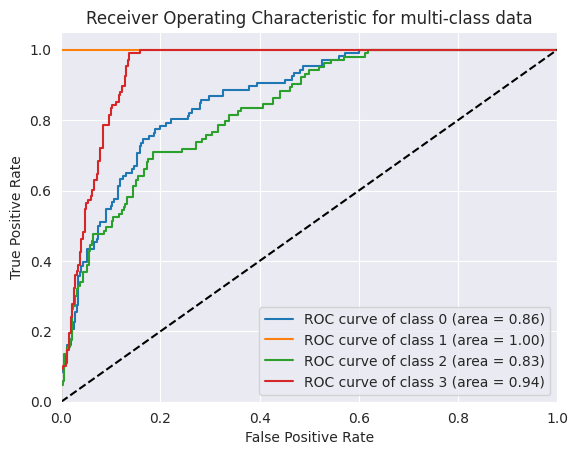

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [ ]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_31 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_32 (Dense)            (None, 4)                 4100      
                                                          

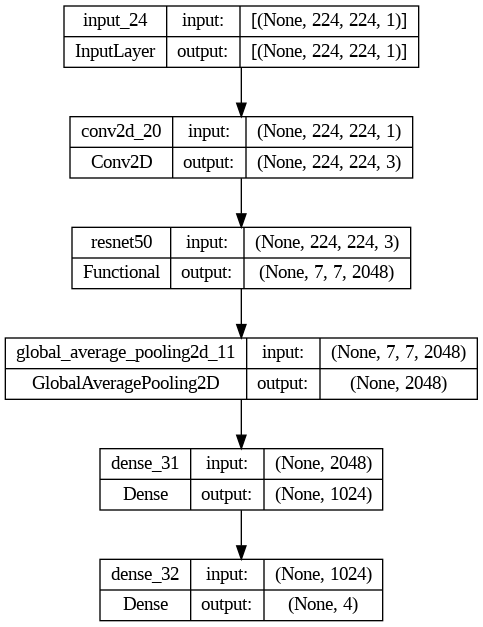

In [ ]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [ ]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 32s 264ms/step - loss: 0.6214 - accuracy: 0.7831 - val_loss: 0.3882 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 27s 255ms/step - loss: 0.3852 - accuracy: 0.8510 - val_loss: 0.6387 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 27s 253ms/step - loss: 0.3180 - accuracy: 0.8770 - val_loss: 0.4072 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 27s 253ms/step - loss: 0.2819 - accuracy: 0.8885 - val_loss: 0.3710 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 27s 255ms/step - loss: 0.2717 - accuracy: 0.8888 - val_loss: 0.5554 - val_accuracy: 0.8005 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 27s 254ms/step - loss: 0.2600 - accuracy: 0.8982 - val_loss: 0.2813 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

ResNet50 Evaluation

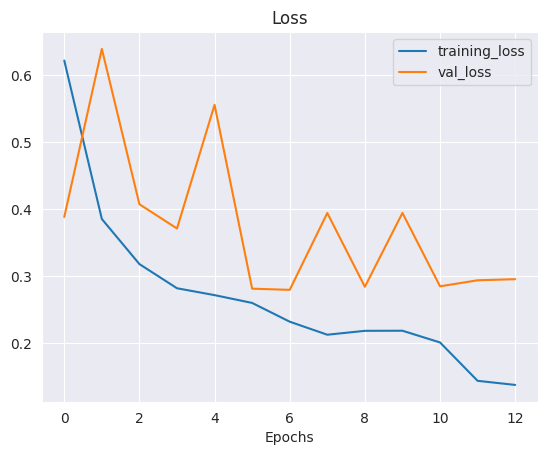

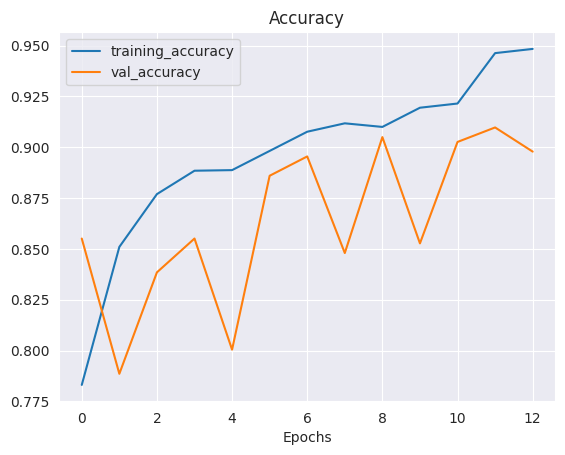

In [ ]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 89ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       106
           1       0.99      1.00      1.00       111
           2       0.81      0.81      0.81       103
           3       0.88      0.82      0.85       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428

Specificity: [0.296969696969697, 0.3501577287066246, 0.24057971014492754, 0.26253687315634217]
Mean Squared Error: : 0.10997746884822845
The average AUC-ROC is 0.9809974670046959


[0.9746031746031746,
 0.6645569620253164,
 0.6901840490797546,
 0.6850152905198776,
 0.6476190476190476,
 1.0,
 0.6595092024539877,
 0.6605504587155964,
 0.707936507936508,
 0.6740506329113924,
 0.9386503067484663,
 0.7125382262996942,
 0.6698412698412698,
 0.6613924050632911,
 0.7116564417177914,
 0.9418960244648318]

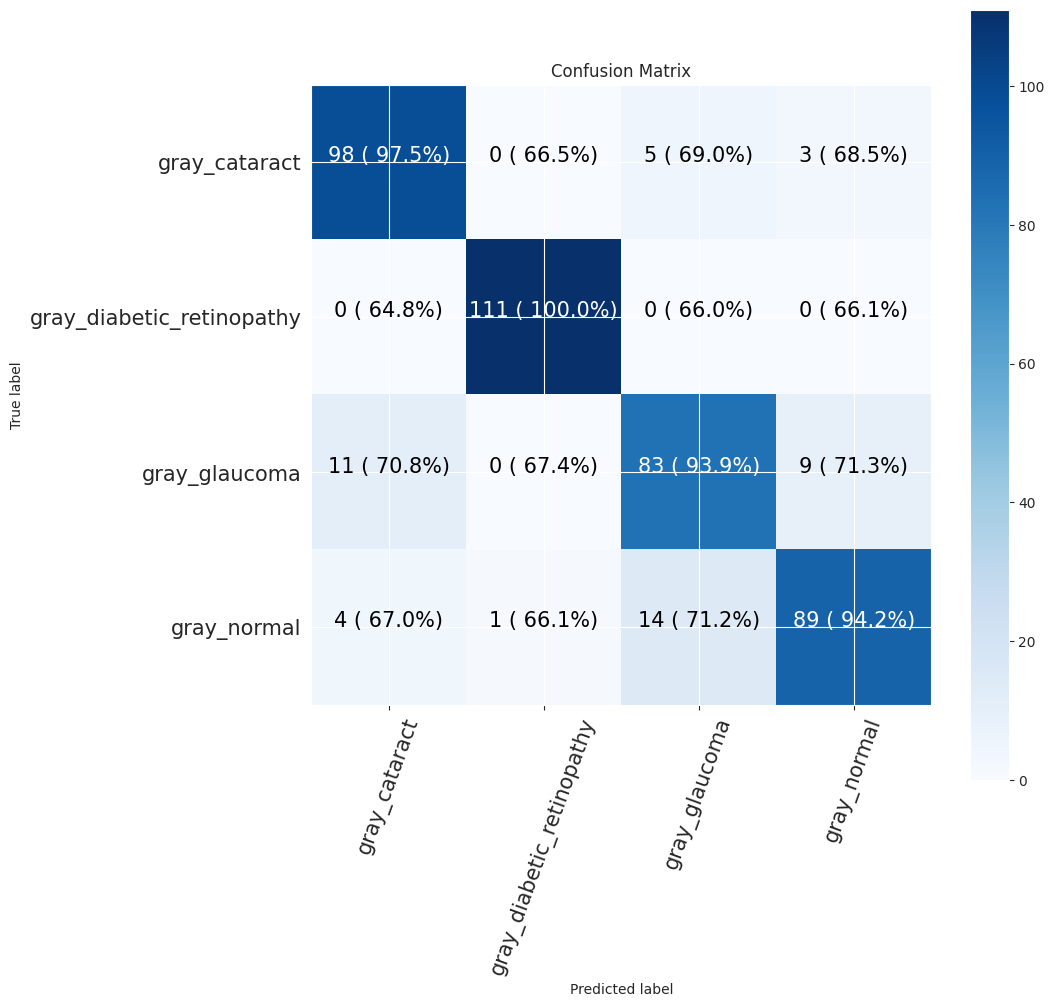

In [ ]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


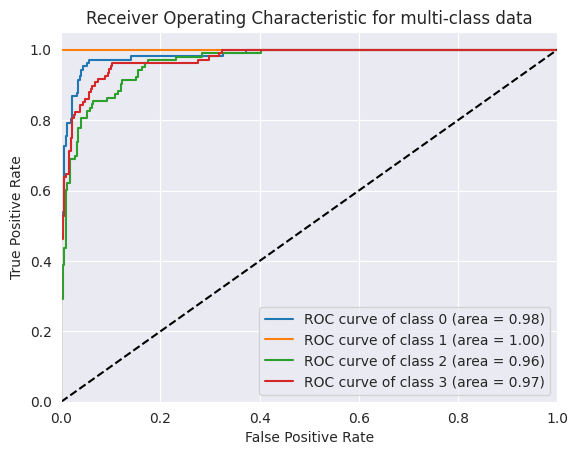

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [ ]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_33 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_34 (Dense)            (None, 4)                 4100      
                                                          

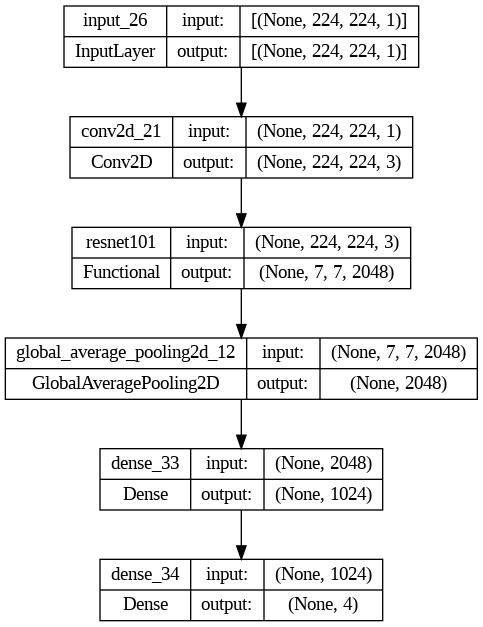

In [ ]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [ ]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 53s 439ms/step - loss: 0.7057 - accuracy: 0.7510 - val_loss: 0.7062 - val_accuracy: 0.7197 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 44s 416ms/step - loss: 0.3998 - accuracy: 0.8507 - val_loss: 0.4397 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 44s 419ms/step - loss: 0.3085 - accuracy: 0.8852 - val_loss: 0.3698 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 44s 417ms/step - loss: 0.2532 - accuracy: 0.9020 - val_loss: 0.3227 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 44s 418ms/step - loss: 0.2305 - accuracy: 0.9091 - val_loss: 0.3737 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 44s 418ms/step - loss: 0.1944 - accuracy: 0.9248 - val_loss: 0.4152 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

ResNet101 Evaluation

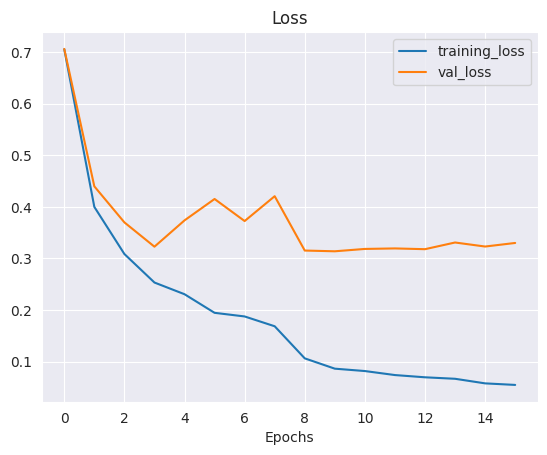

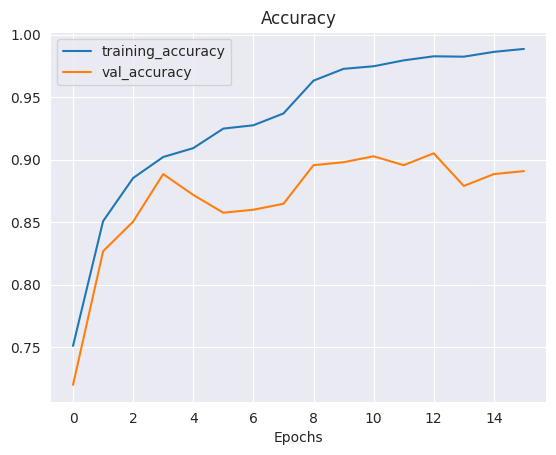

In [ ]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 2s 152ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       106
           1       0.97      1.00      0.99       111
           2       0.78      0.81      0.79       103
           3       0.91      0.81      0.86       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428

Specificity: [0.296969696969697, 0.3501577287066246, 0.24057971014492754, 0.25882352941176473]
Mean Squared Error: : 0.11014685779809952
The average AUC-ROC is 0.9805471775642777


[0.9748427672955975,
 0.6624203821656051,
 0.6915887850467289,
 0.6827794561933535,
 0.6509433962264151,
 1.0,
 0.6542056074766355,
 0.6646525679758308,
 0.710691823899371,
 0.6751592356687898,
 0.9376947040498442,
 0.7129909365558912,
 0.6635220125786163,
 0.6624203821656051,
 0.7165109034267912,
 0.9395770392749244]

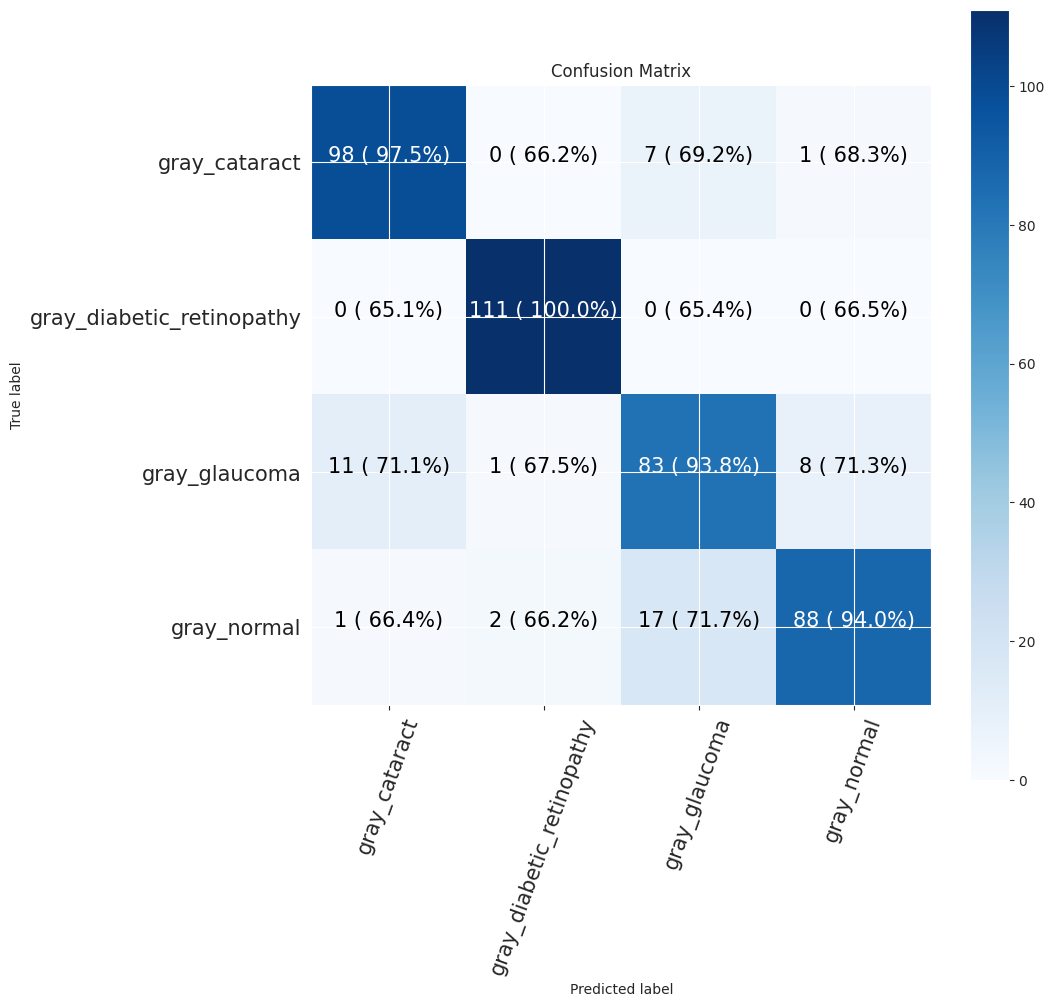

In [ ]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


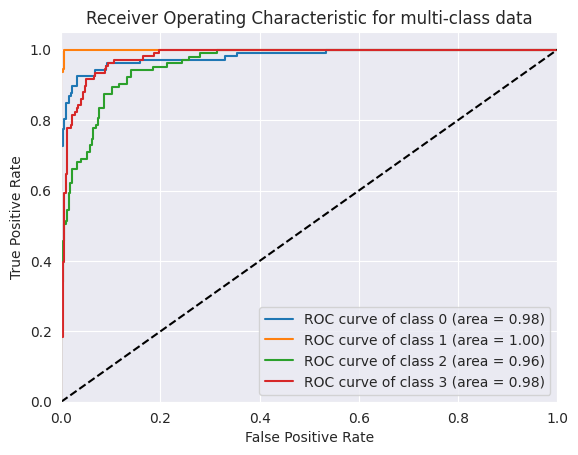

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [7]:
epoch = 20
batchsize = 64

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 421 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [ ]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [ ]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_6  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 32)                49184     
                                                                 
 dense_19 (Dense)            (None, 4)                 132       
                                                                 
 activation_2 (Activation)   (None, 4)                 0   

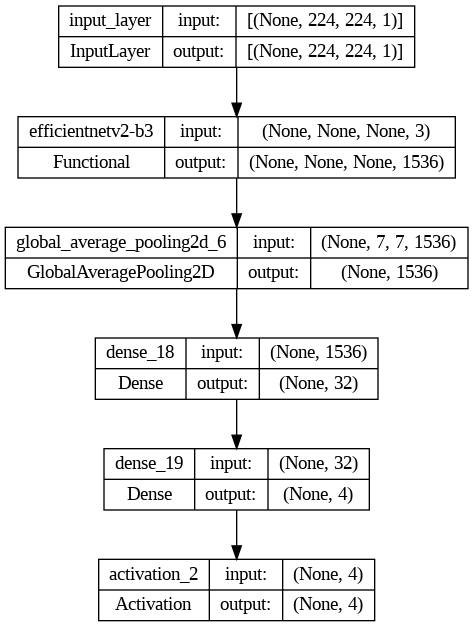

In [ ]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [ ]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 25s 266ms/step - loss: 0.7159 - accuracy: 0.7167 - val_loss: 0.5202 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 11s 198ms/step - loss: 0.4863 - accuracy: 0.8179 - val_loss: 0.4506 - val_accuracy: 0.8385 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 10s 182ms/step - loss: 0.4440 - accuracy: 0.8374 - val_loss: 0.4285 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 10s 182ms/step - loss: 0.4056 - accuracy: 0.8474 - val_loss: 0.4031 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 10s 181ms/step - loss: 0.3988 - accuracy: 0.8542 - val_loss: 0.3733 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 10s 179ms/step - loss: 0.3632 - accuracy: 0.8719 - val_loss: 0.3597 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 10s 178ms/st

EfficientNetV2B3 Evaluation

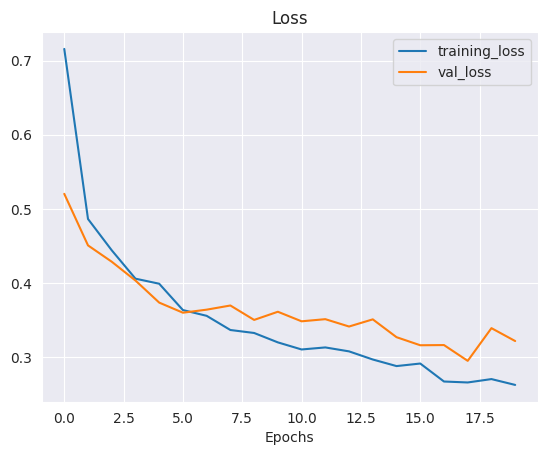

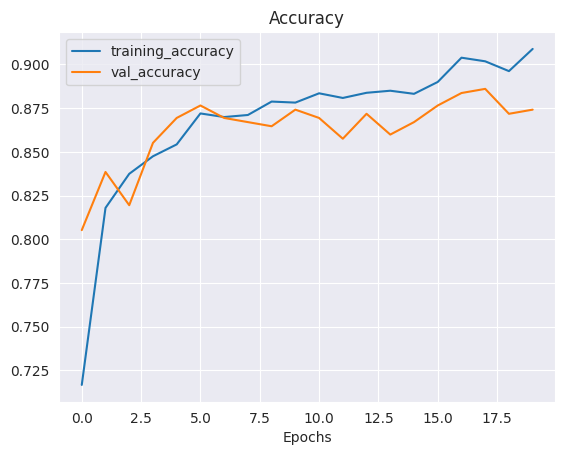

In [ ]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 143ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       106
           1       0.97      0.97      0.97       111
           2       0.87      0.79      0.83       103
           3       0.88      0.86      0.87       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.90      0.89      0.89       428

Specificity: [0.308868501529052, 0.3375, 0.2334293948126801, 0.27761194029850744]
Mean Squared Error: : 0.11195996403694153
The average AUC-ROC is 0.9858610080501716


[0.9838709677419355,
 0.6656151419558359,
 0.6895522388059702,
 0.6801242236024845,
 0.6451612903225806,
 0.9905362776025236,
 0.6686567164179105,
 0.6614906832298136,
 0.7096774193548387,
 0.6782334384858044,
 0.9343283582089552,
 0.7049689440993789,
 0.6612903225806451,
 0.6656151419558359,
 0.7074626865671642,
 0.953416149068323]

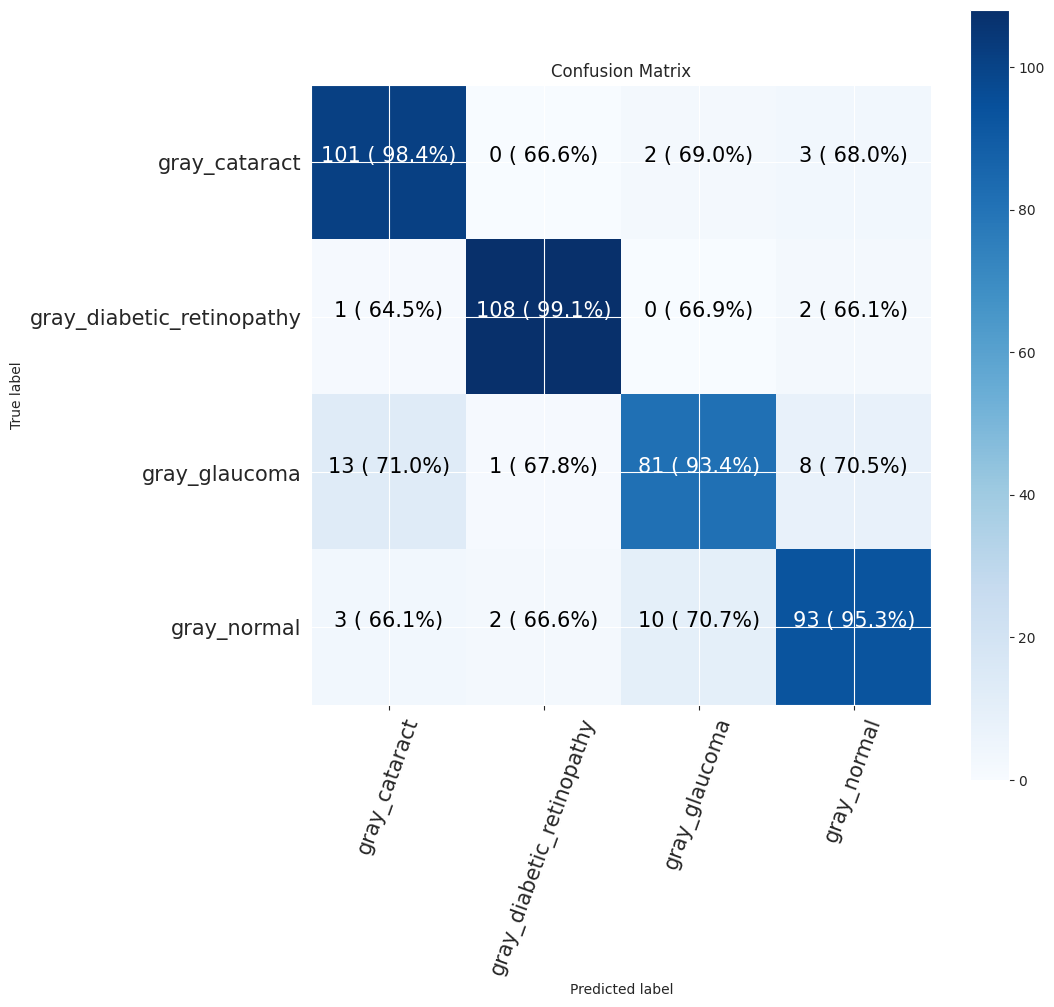

In [ ]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


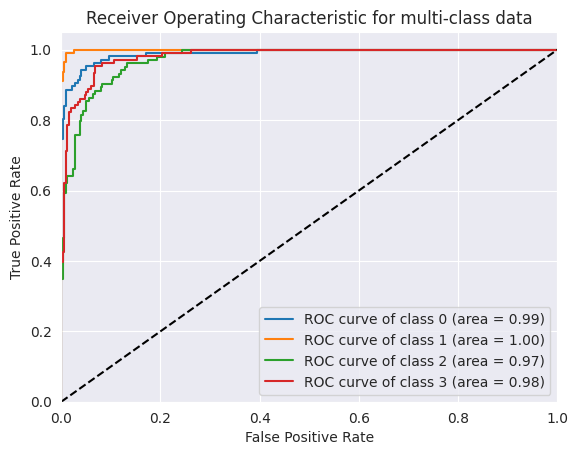

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [ ]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 128)      

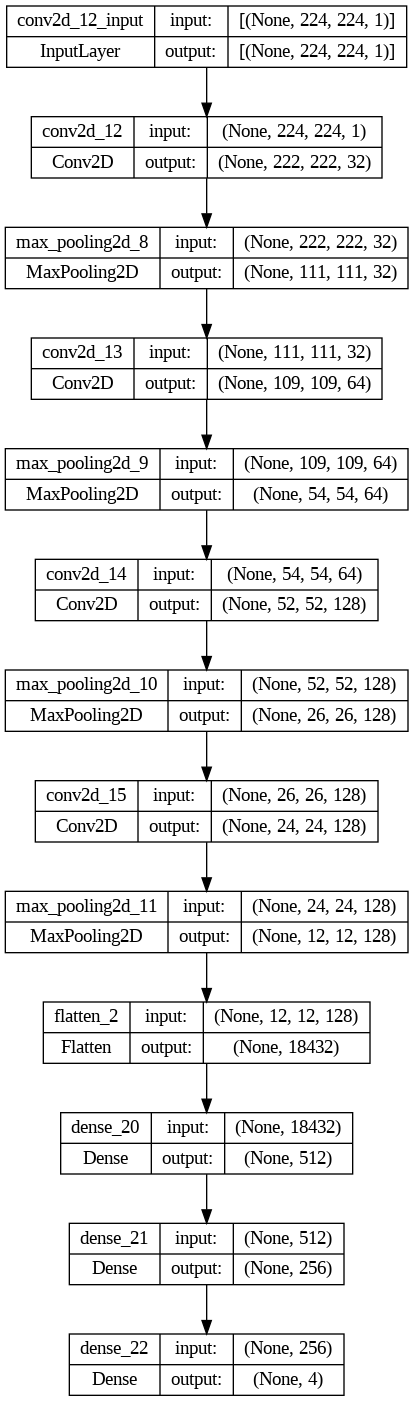

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [ ]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 8s 92ms/step - loss: 6.1558 - accuracy: 0.4842 - val_loss: 0.9696 - val_accuracy: 0.5772 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 4s 63ms/step - loss: 0.7102 - accuracy: 0.6831 - val_loss: 0.6983 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 4s 64ms/step - loss: 0.6478 - accuracy: 0.7176 - val_loss: 0.6121 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 4s 64ms/step - loss: 0.5416 - accuracy: 0.7645 - val_loss: 0.5631 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 4s 63ms/step - loss: 0.5096 - accuracy: 0.7678 - val_loss: 0.5433 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 4s 64ms/step - loss: 0.4748 - accuracy: 0.7979 - val_loss: 0.4713 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 4s 64ms/step - loss: 0.4

CNN Evaluation

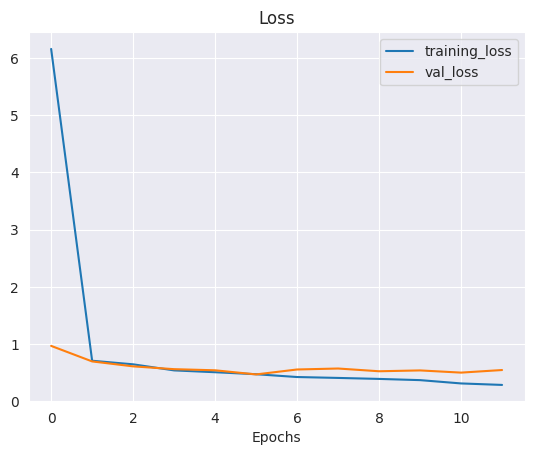

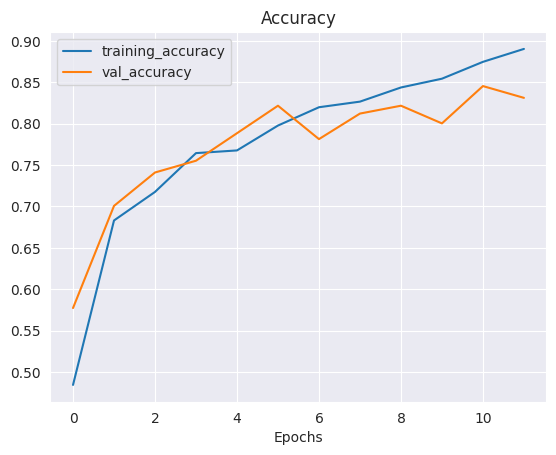

In [ ]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 22ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       106
           1       1.00      1.00      1.00       111
           2       0.71      0.75      0.73       103
           3       0.78      0.89      0.83       108

    accuracy                           0.84       428
   macro avg       0.84      0.84      0.84       428
weighted avg       0.85      0.84      0.84       428

Specificity: [0.2159090909090909, 0.3501577287066246, 0.21937321937321938, 0.2891566265060241]
Mean Squared Error: : 0.11991812288761139
The average AUC-ROC is 0.961837193378799


[0.9122807017543859,
 0.6656151419558359,
 0.734375,
 0.6819672131147541,
 0.6754385964912281,
 1.0,
 0.653125,
 0.6360655737704918,
 0.7222222222222222,
 0.6750788643533123,
 0.91875,
 0.7213114754098361,
 0.6900584795321637,
 0.6593059936908517,
 0.69375,
 0.9606557377049181]

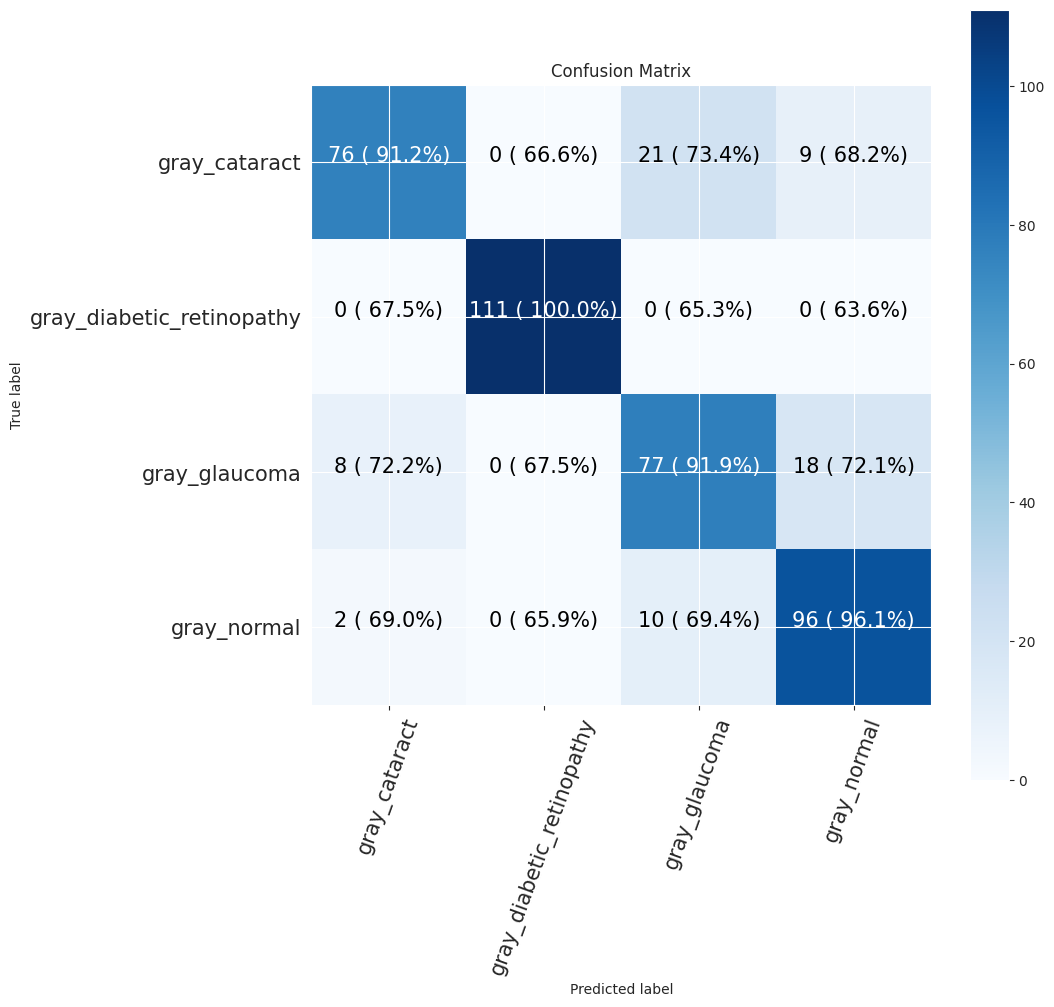

In [ ]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


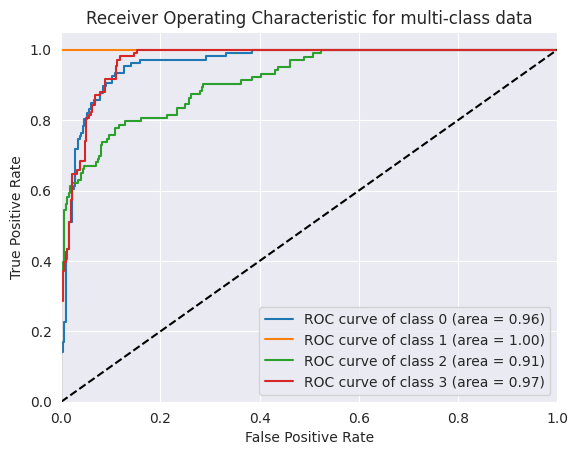

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [ ]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_35 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_36 (Dense)            (None, 4)                 4100      
                                                          

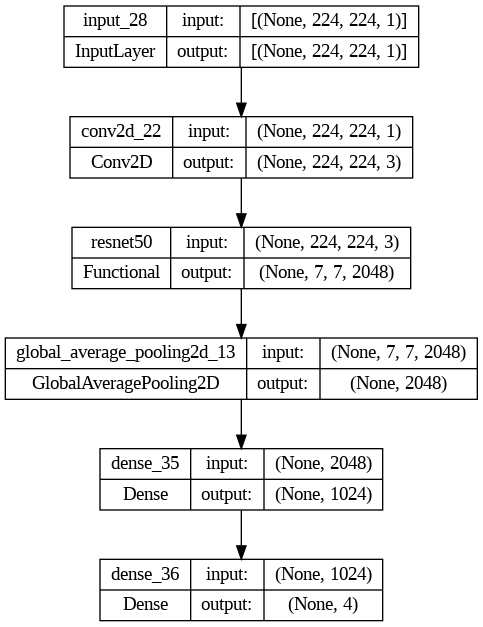

In [ ]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [ ]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 31s 508ms/step - loss: 0.8652 - accuracy: 0.7164 - val_loss: 0.4818 - val_accuracy: 0.8005 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 26s 491ms/step - loss: 0.4154 - accuracy: 0.8421 - val_loss: 0.3563 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 26s 487ms/step - loss: 0.3410 - accuracy: 0.8740 - val_loss: 0.3665 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 26s 488ms/step - loss: 0.2942 - accuracy: 0.8885 - val_loss: 0.3681 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 26s 489ms/step - loss: 0.2697 - accuracy: 0.8950 - val_loss: 0.2911 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 26s 489ms/step - loss: 0.2520 - accuracy: 0.9035 - val_loss: 0.3827 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 26s 488ms/st

ResNet50 Evaluation

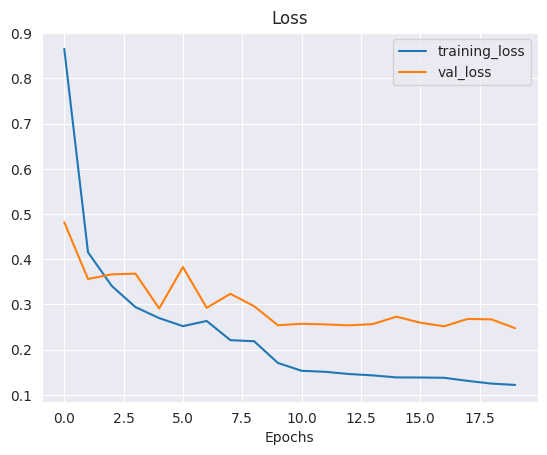

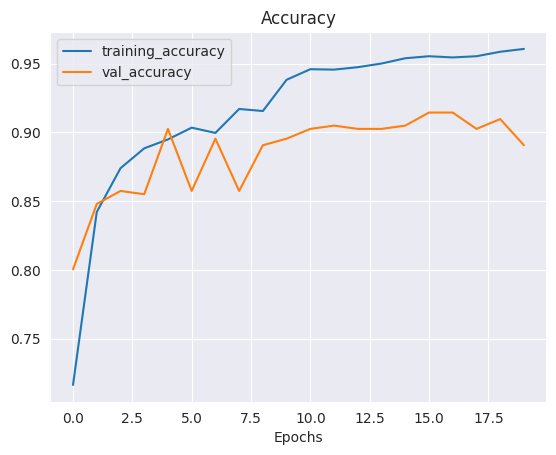

In [ ]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 171ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       106
           1       0.98      1.00      0.99       111
           2       0.85      0.79      0.82       103
           3       0.88      0.86      0.87       108

    accuracy                           0.90       428
   macro avg       0.90      0.90      0.89       428
weighted avg       0.90      0.90      0.90       428

Specificity: [0.3009118541033435, 0.3501577287066246, 0.2334293948126801, 0.27761194029850744]
Mean Squared Error: : 0.11100538074970245
The average AUC-ROC is 0.9835454595350539


[0.9777070063694268,
 0.6634920634920635,
 0.6936936936936937,
 0.6801242236024845,
 0.6464968152866242,
 1.0,
 0.6666666666666666,
 0.65527950310559,
 0.7038216560509554,
 0.6793650793650794,
 0.933933933933934,
 0.7111801242236024,
 0.6719745222929936,
 0.6571428571428571,
 0.7057057057057057,
 0.953416149068323]

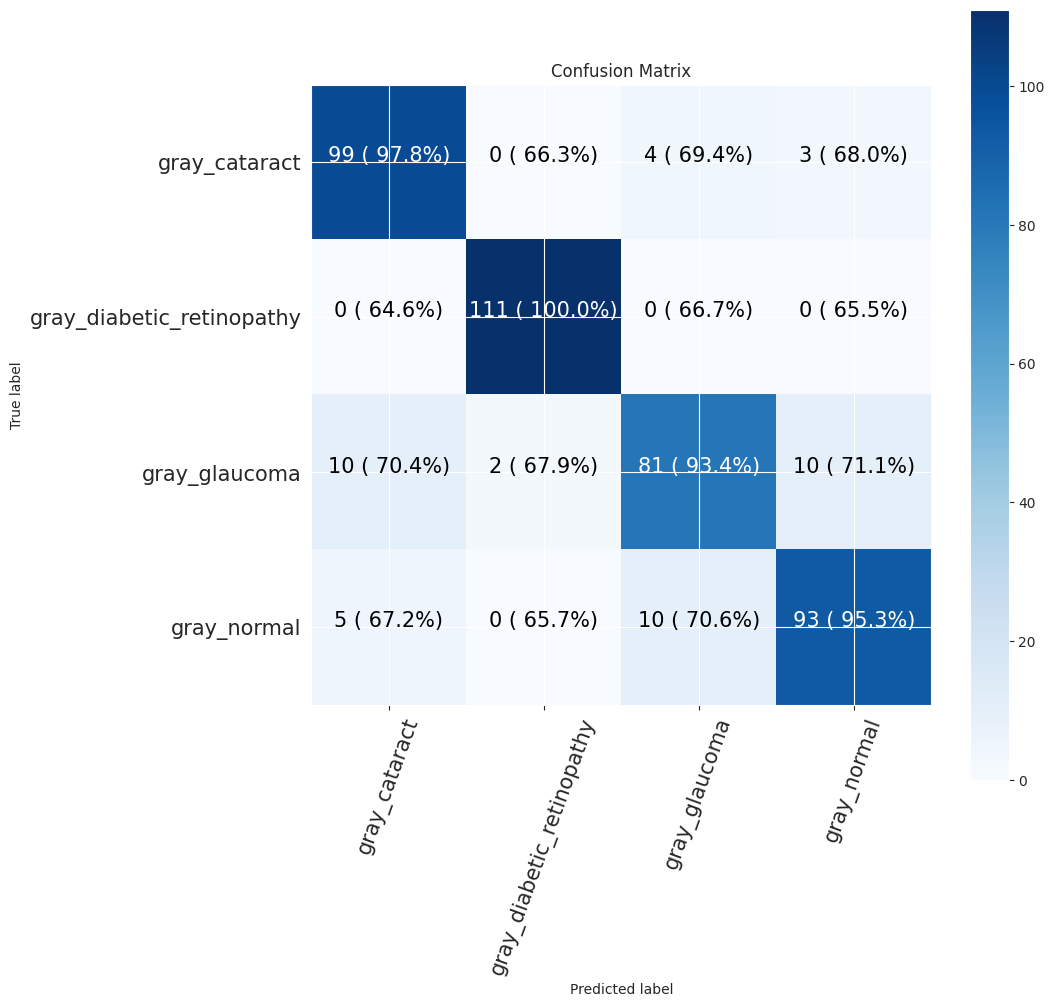

In [ ]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


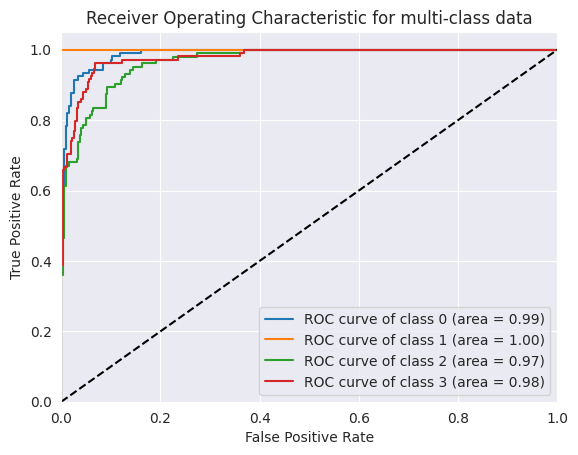

In [ ]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [9]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
# grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


171446536/171446536 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 4)                 4100 

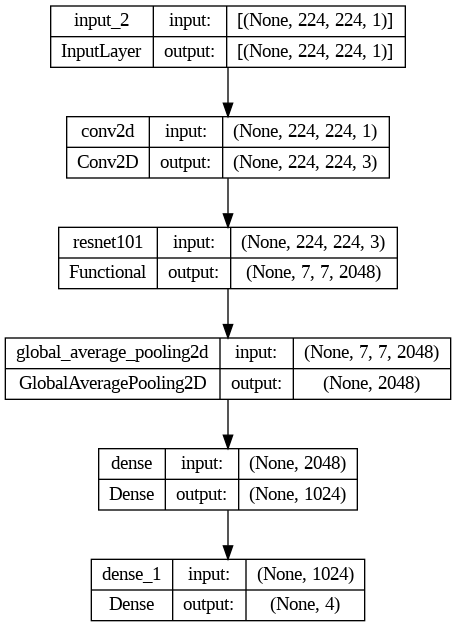

In [10]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [11]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [12]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 66s 891ms/step - loss: 0.9125 - accuracy: 0.7020 - val_loss: 0.4615 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 43s 805ms/step - loss: 0.4040 - accuracy: 0.8436 - val_loss: 0.3858 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 43s 815ms/step - loss: 0.3473 - accuracy: 0.8675 - val_loss: 0.3639 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 43s 811ms/step - loss: 0.2947 - accuracy: 0.8908 - val_loss: 0.3314 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 43s 814ms/step - loss: 0.2732 - accuracy: 0.8991 - val_loss: 0.3174 - val_accuracy: 0.8765 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 43s 811ms/step - loss: 0.2653 - accuracy: 0.8973 - val_loss: 0.3614 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 43s 813ms/st

ResNet101 Evaluation

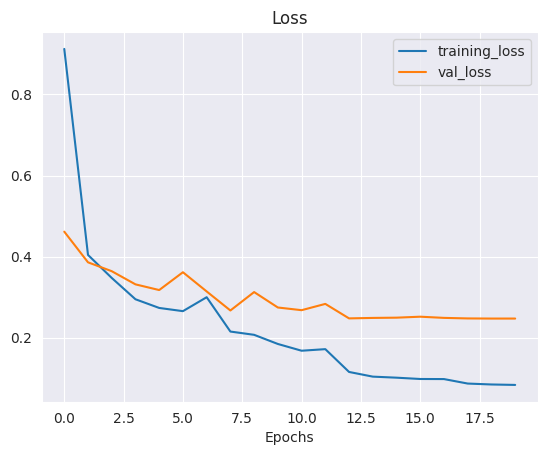

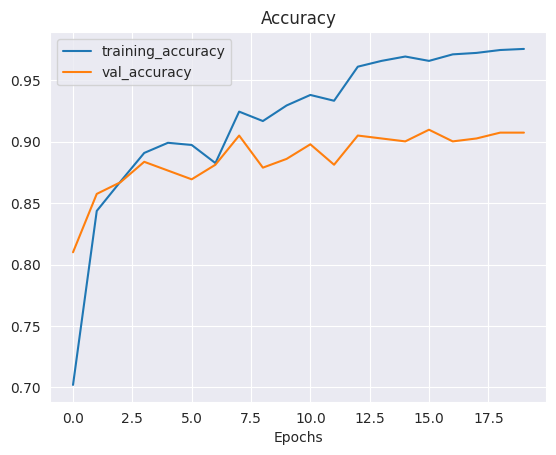

In [13]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 2s 295ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       106
           1       0.97      0.97      0.97       111
           2       0.85      0.85      0.85       103
           3       0.90      0.88      0.89       108

    accuracy                           0.91       428
   macro avg       0.91      0.91      0.91       428
weighted avg       0.91      0.91      0.91       428

Specificity: [0.296969696969697, 0.3375, 0.25882352941176473, 0.2852852852852853]
Mean Squared Error: : 0.10948124527931213
The average AUC-ROC is 0.9819985926230473


[0.975,
 0.668769716088328,
 0.6861538461538461,
 0.6801242236024845,
 0.653125,
 0.9905362776025236,
 0.6646153846153846,
 0.6583850931677019,
 0.7,
 0.6782334384858044,
 0.9538461538461539,
 0.7018633540372671,
 0.671875,
 0.6624605678233438,
 0.6953846153846154,
 0.9596273291925466]

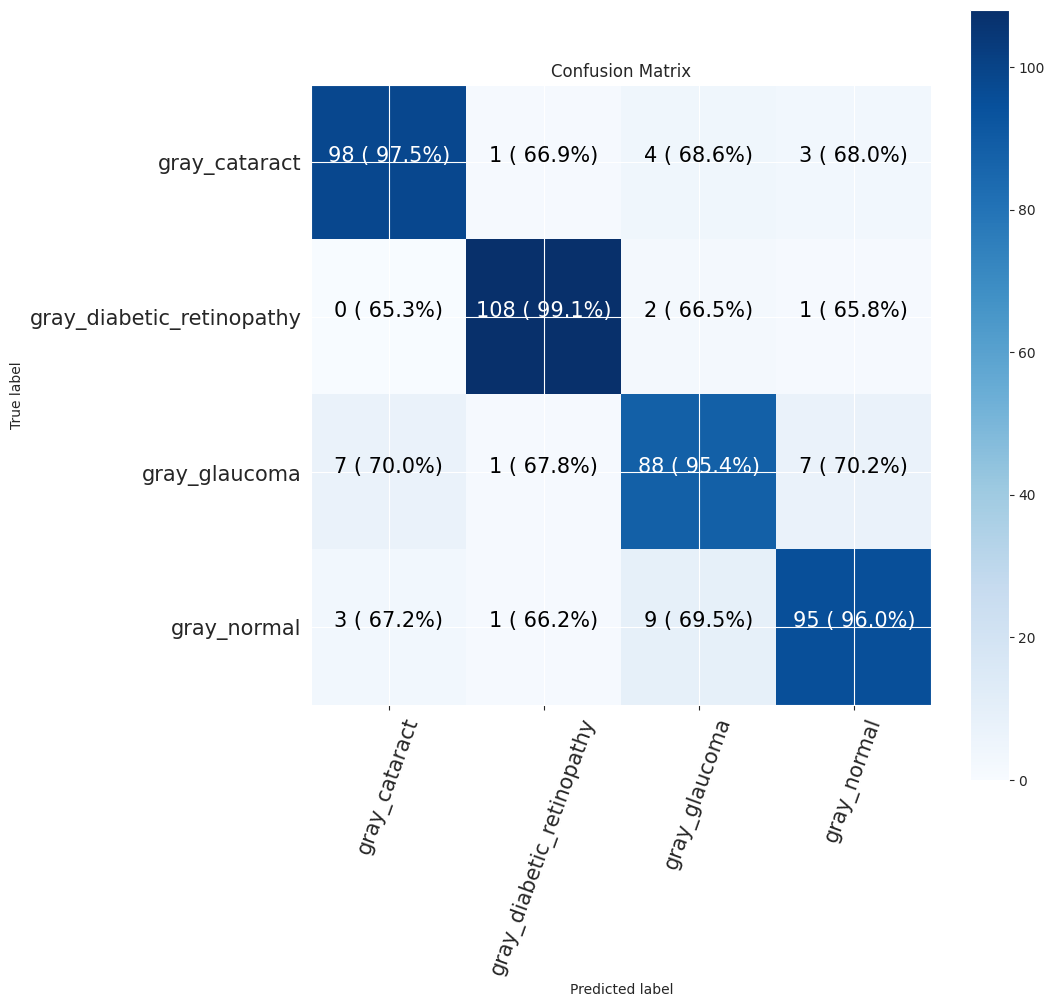

In [14]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


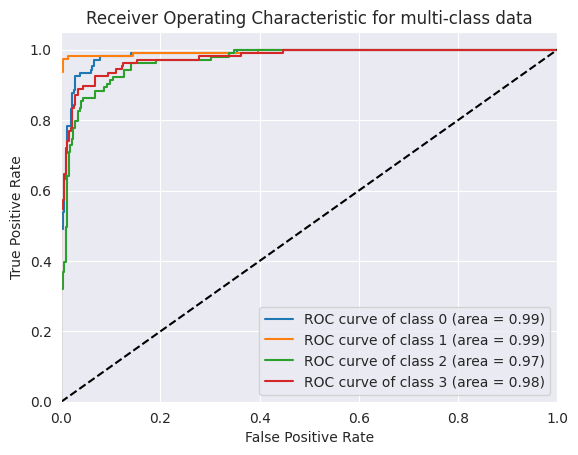

In [15]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()